# Exercise Climate Networks of Indian Monsoon

In this exercise we will explore patterns of rainfall in India during the monsoon (June-July-August-September; JJAS) season.  
We will proceed similarly as in the tutorial:  
1. Load data and preprocess 
2. Pairwise-Intercomparison between all time series
3. Generate Correlation matrix
4. Cluster based on hierarchical tree


In [15]:
# import required packages
import xarray as xr
import numpy as np
import geoutils.plotting.plots as gplt
import geoutils.geodata.base_dataset as bds
import geoutils.utils.time_utils as tu
import geoutils.utils.statistic_utils as sut
import geoutils.utils.general_utils as gut
from importlib import reload

plot_dir = "/home/strnad/data/plots/tutorials/clustering_india/"
data_dir = "/home/strnad/data/"

## Get Familiar with the data
The data is loaded using the package xarray.  

**Exercise :** The data is provided as daily data. However, precipititation data is very stochastic.  
We therefore analyze weekly data, to better average out daily variations.



In [59]:
# Load the data to an xarray dataset
# Load the dataset
grid_step = 1
dataset_file = data_dir + \
    f"climate_data/{grid_step}/mswep_pr_{grid_step}_ds.nc"

# India
lon_range_cut = [60, 90]
lat_range_cut = [-0, 30]

ds_pr = bds.BaseDataset(data_nc=dataset_file,
                        can=True,
                        an_types=['dayofyear', 'month', 'JJAS'],
                        lon_range=lon_range_cut,
                        lat_range=lat_range_cut,
                        month_range=['Jun', 'Sep']
                        )


File location: /home/strnad/data/climate_data/1/mswep_pr_1_ds.nc
File size: 3.70 GB
Start processing data!
3d object transposed to lat-lon-time!
Sorted longitudes and latitudes in ascending order!
Set time to np.datetime[ns] time format!
set hours to 0
Load data from in time range (numpy.datetime64('1979-01-02'), numpy.datetime64('2020-12-30'))!
Select data from Jun - Sep!
Cut the dataset [60, 90], [0, 30]!
Different grid step in lon 1.0 and lat 1.01 direction!
Finished processing data
Set variable name to pr!
Created dayofyearly anomalies!
Rename pr to pr_an_dayofyear!
Created monthly anomalies!
Rename pr to pr_an_month!
Created JJASly anomalies!
Rename pr to pr_an_JJAS!
No mask initialized!
Set dataset source attributes!


**Exercise** Get familiar with the annual means and the Quantiles:  
Plot the mean precipitation over the Indian JJAS monsoon season using cartopy as well as 
the 0.9 quantile.

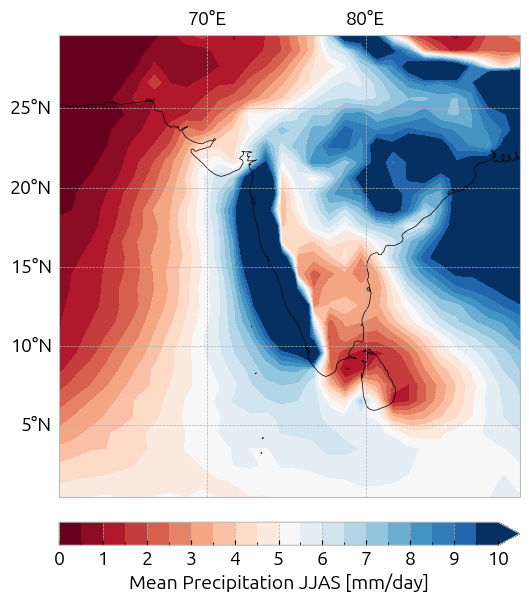

In [60]:
reload(gplt)
var_name = 'pr'
mean_pr = tu.compute_mean(ds_pr.ds['pr'])
im = gplt.plot_map(mean_pr,
                   label='Mean Precipitation JJAS [mm/day]',
                  projection='PlateCarree',
                  cmap='RdBu',
                  levels=20,
                  vmin=0, vmax=10)

## Clustering of climate data

**Exercise :** Compute the clusters of based on complete linkage clustering of the Spearman's Correlation Matrix!  
You might follow the method from [Rheinwalt et al. 2015](https://link.springer.com/chapter/10.1007/978-3-319-17220-0_3), moreover our results can be compared to [Malik et al., 2010]( www.nonlin-processes-geophys.net/17/371/2010/) .  
You can use the functions below or try out another clustering Algorithm!

In [50]:
def get_distance(corr, pvalue, confidence=0.999, threshold=None):
    """Get correlation and distance threshold for a given confidence level.

    Note: only positive correlations are considered here

    Return:
    -----
    threshold: float
        Threshold where the clustering is stopped
    distance: np.ndarray (n, n)
        Distance matrix
    corr_pos: np.ndarray (n, n)
        Correlation matrix with only positive correlations
    """
    # get only absolute correlations
    corr_pos = np.abs(corr)

    # get distance matrix
    distance = np.arccos(corr_pos)

    # consider only correlations with corresponding pvalues smaller than (1-confidence)
    mask_confidence = np.where(pvalue <= (
        1 - confidence), 1, 0)  # p-value test
    corr_pos = np.where(mask_confidence == 1, corr_pos, np.nan)

    # get threshold
    if threshold is None:
        idx_min = np.unravel_index(
                np.nanargmin(corr_pos.data), np.shape(corr_pos.data)
            )
    else:
        mask_corr = np.where(corr_pos >= threshold,
                             corr_pos, np.nan)
        idx_min = np.unravel_index(
                np.nanargmin(mask_corr.data), np.shape(corr_pos.data)
            )
    threshold_corr = corr_pos[idx_min]
    threshold_dist = distance[idx_min]

    print(f"p-value {pvalue[idx_min]}, \n",
          f"correlation {threshold_corr} \n",
          f"Min distance threshold {threshold_dist}")

    return distance, threshold_dist

def complete_linkage_cluster(distance, threshold=None, linkage="complete", n_clusters=None):
        """Complete linkage clustering.
        Return:
        -------
        labels: list (n)
            Cluster label of each datapoint
        model: sklearn.cluster.AgglomerativeClustering
            Complete linkage clustering model
        """
        # Use Scipy Agglomerative Clustering for distances clustering!
        from sklearn.cluster import AgglomerativeClustering
        if n_clusters is not None:
            # Exactly one of n_clusters and distance_threshold has to be set,
            # and the other needs to be None. Here we set n_clusters if given!
            threshold = None

        # create hierarchical cluster
        model = AgglomerativeClustering(
            distance_threshold=threshold,
            n_clusters=n_clusters,
            compute_full_tree=True,
            connectivity=None,
            linkage=linkage
        )
        labels = model.fit_predict(distance)
        print(
            f"Found {np.max(labels)+1} clusters for the given threshold {threshold}.")
        return labels, model


In [64]:
da = ds_pr.ds['an_dayofyear']  # Use the anomaly data to compute the pairwise correlations
print('Dataset shape: ', da.shape)
dim_lat, dim_lon, dim_time = da.shape
# Bring all into a form of an array of time series
data = []
data = []
for idx, t in enumerate(da.time):
        buff = da.sel(time=t.data).data.flatten()  # flatten each time step
        buff[np.isnan(buff)] = 0.0  # set missing data to climatology
        data.append(buff)
data = np.array(data)
print('Flattend Dataset shape: ', data.shape)
corr, pvalue =  sut.calc_spearman(data)
print('Shape of correlation Matrix: ', corr.shape)


Dataset shape:  (30, 30, 5124)
Flattend Dataset shape:  (5124, 900)
Shape of correlation Matrix:  (900, 900)


In [65]:
num_clusters = 7
distance, threshold_dist = get_distance(corr=corr, pvalue=pvalue, threshold=0.1)
clusterIds, model = complete_linkage_cluster(distance=distance,
                                             threshold=threshold_dist,
                                             n_clusters=num_clusters)

p-value 7.255560527210199e-13, 
 correlation 0.10000105560390643 
 Min distance threshold 1.4706278447114363
Found 7 clusters for the given threshold None.


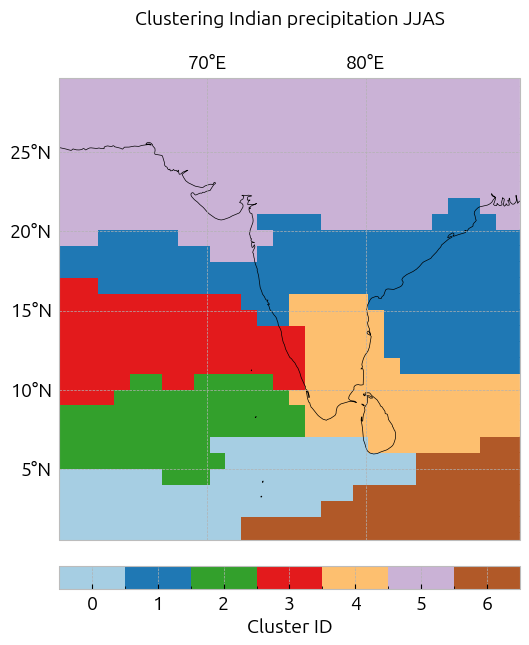

In [72]:
cluster_map = gut.create_xr_ds(data=clusterIds.reshape(dim_lat, dim_lon),
                               dims=['lat', 'lon'],
                               coords={'lat': ds_pr.ds.lat,
                                       'lon': ds_pr.ds.lon},
                               name='Cluster')
im = gplt.plot_map(cluster_map,
                   cmap='Paired',
                   title='Clustering Indian precipitation JJAS',
                   y_title=1.1,
                   label='Cluster ID',
                   plot_type='colormesh',
                   vmin=0, vmax=num_clusters,
                   levels=num_clusters,
                   shift_ticks=True,
                   set_int=True,
                   tick_step=1,
                   )
savepath = plot_dir + f'clustering_indian_pr.png'
gplt.save_fig(savepath=savepath)

## Comparison of Climate Networks to PCA

Climate networks represent a non-linear transformations of the data in order to reduce the dimensionality of the data. PCA is a linear transformation used as well for dimensionality reduction. We can compare the Principial Components to the Network measures to climate network.

**Exercise :**  Apply a PCA on the precipitation anomaly data, visualize the EOF map of the first two components. What do you see by comparing them to node degree plots of the climate network? Do you have an explanation for this similarity?

*Hint: You might have a look at [Donges et al., 2015](https://link.springer.com/article/10.1007/s00382-015-2479-3)!*

In [29]:
from sklearn.decomposition import PCA
pca_data = np.array(data)

pca = PCA(n_components=5)
z = pca.fit_transform(pca_data)

Text(0.5, 1.0, 'EOF 1')

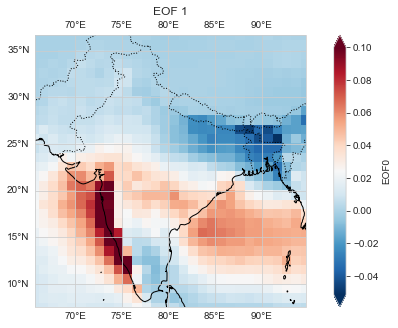

In [36]:
# Plot EOF maps
i = 0
eof_map = put.create_map_for_da(da=ds[var_name], data=pca.components_[i].reshape(dim_lat, dim_lon),
                            name=f'EOF{i}')
im = put.plot_map(eof_map, bar=True,
                  cmap='RdBu_r',
                  central_longitude=0,
                  vmax=0.1)

im['ax'].set_title(f"EOF {i+1}")

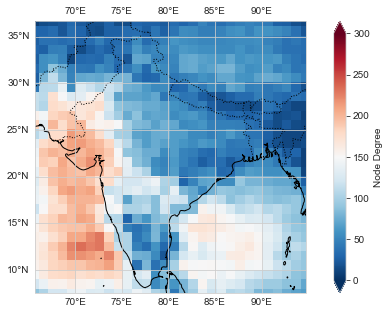

In [40]:
degrees = np.array(cnx.degree())[:,1] # This returns the list of degrees
# Plot degrees
degree_arr = np.array(cnx.degree())[:,1].reshape(dim_lat, dim_lon)
degree_map = put.create_map_for_da(da=ds[var_name], data=degree_arr, name='degree')
im = put.plot_map(degree_map,
                  label='Node Degree',
                  vmin=0,
                  vmax=300)